In [23]:
from numpy import load
import pickle
import scipy
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Look into partial fitting. 
# Dataset is not evenly distributed with most being 1.
# Dummy Classifier has 50 % accuracy score... (Only give instances the most frequent label)



# steps_countvec = scipy.sparse.load_npz('recipe_text_features_countvec/train_steps_countvectorizer.pkl')

# Doc2Vect is a technique to transfer words into numerical representation. 
# https://www.shibumi-ai.com/post/a-gentle-introduction-to-doc2vec
# https://www.shibumi-ai.com/post/a-gentle-introduction-to-doc2vec
d2v_ingr = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_ingr_doc2vec100.csv", header=None)
d2v_name = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_name_doc2vec100.csv", header=None)
d2v_steps = pd.read_csv("../data/COMP30027_2021_Project2_datasets/recipe_text_features_doc2vec100/train_steps_doc2vec100.csv", header=None)




# Extract class_labels from training set 
# quick = 1
# medium = 2
# slow = 3
# slow = 3
data_train = pd.read_csv('../data/COMP30027_2021_Project2_datasets/recipe_train.csv')

# Obtain the labels
train_label = data_train.iloc[:,-1]




# Feature selection with f_classif (ANOVA F-value)
# ANOVA f-value shows how well a feature discriminate between classes
# The more discrimination, the better that feature is in predicting the class label.
# d2v_name_new = SelectKBest(k=90).fit_transform(d2v_name, train_label)
# d2v_ingr_new = SelectKBest(k=90).fit_transform(d2v_ingr, train_label)
# d2v_steps_new = SelectKBest(k=90).fit_transform(d2v_steps, train_label)
d2v_name_new = pd.DataFrame(d2v_name)
d2v_ingr_new = pd.DataFrame(d2v_ingr)
d2v_steps_new = pd.DataFrame(d2v_steps)
# print(d2v_ingr_new)
# print(d2v_steps_new)
# print(d2v_name_new.shape)


# Create a new dataframe of data, but this time, name, steps and ingr has been engineered to have doc2vec features.
# 100 doc2vec features were given, but we selected 20 best features using ANOVA f-value.
f_data = d2v_name_new.join(data_train.iloc[:,1:3], on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = d2v_name_new.join(d2v_steps_new, on=None, how='left', lsuffix='_left', rsuffix='_right')
f_data = f_data.join(d2v_ingr_new, on=None, how='left', lsuffix='_left', rsuffix='_right')


# Standardise the data so that the mean is 0
scaler = StandardScaler()
f_data = scaler.fit_transform(f_data)

# normalise all values to be between 0 and 1
minmax_scaler = MinMaxScaler()
f_data = minmax_scaler.fit_transform(f_data)
   
        
           


# Oversampling, because the distribution of classes in training data is highly skewed towards quick and medium.
oversample = RandomOverSampler(sampling_strategy='minority')

# First random oversampling, bring count of class 3 to be equal to the highest class count.
X_oversampled, y_oversampled = oversample.fit_resample(f_data, train_label)

# Second random oversampling, bring the count of class 2 to be equal to the other 2 classes
X_oversampled, y_oversampled = oversample.fit_resample(X_oversampled, y_oversampled)




X = pd.DataFrame(X_oversampled)
y = pd.DataFrame(y_oversampled)


smote = SMOTE(random_state=42)
smX, smY = smote.fit_resample(f_data, train_label)


# full = X.join(y, on=None, how='left', lsuffix='_left', rsuffix='_right')
# full.shape
# y_oversampled
smX.shape

(60738, 300)

In [25]:
from sklearn.decomposition import PCA



pca = PCA(n_components=2)
pca.fit(smX)
pca_x=pca.transform(smX)
# test = pd.DataFrame(pca.components_)
pcaX = pd.DataFrame(pca_x)
pcaX
# pcaX.to_csv('pcaX.csv', index=False)

# X_train, X_test, y_train, y_test = train_test_split(pca_x, train_label, test_size=0.2, stratify=train_label, random_state=42)


,0,1
0,-0.163161,0.157439
1,0.121824,-0.003538
2,0.012637,0.037266
3,0.100619,0.063387
4,0.272224,0.071606
...,...,...
60733,-0.253335,-0.156113
60734,-0.063276,-0.061722
60735,-0.087920,-0.053647
60736,-0.121954,0.049366


### PCA, no clear clusters 
bad for KNN   


Text(0, 0.5, 'pc2')

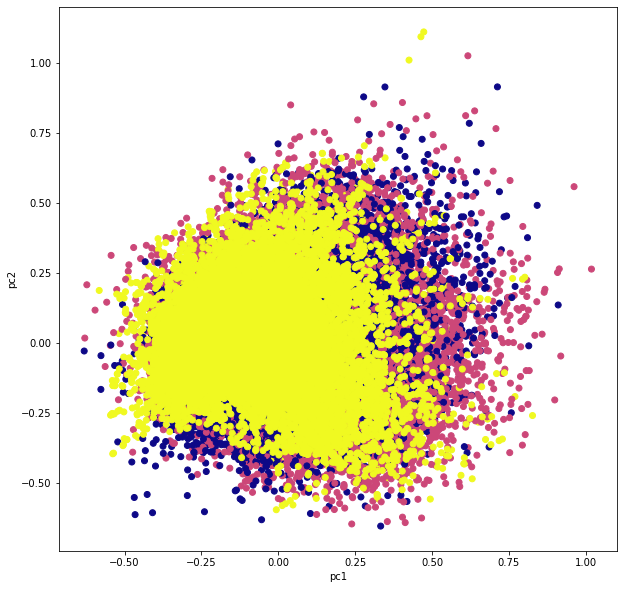

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
plt.scatter(pca_x[:,0],pca_x[:,1],c=smY,cmap='plasma')
plt.xlabel('pc1')
plt.ylabel('pc2')

In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


from sklearn.decomposition import PCA


# pca = PCA(n_components = 2)
# pca.fit(X_oversampled)
# pca_x=pca.transform(X_oversampled)
# # test = pd.DataFrame(pca.components_)


X_train, X_test, y_train, y_test = train_test_split(pca_x, smY, test_size=0.2, stratify=y_oversampled, random_state=42)


knn_clf = KNeighborsClassifier(n_neighbors=10)
knn_clf.fit(X_train, y_train)


knn_predict = knn_clf.predict(X_test)
knn_predict_train = knn_clf.predict(X_train)


print("test", accuracy_score(y_test, knn_predict))
print("train", accuracy_score(y_train, knn_predict_train))
print(classification_report(y_test, knn_predict))

test 0.44468225222258806
train 0.5608561432393496
              precision    recall  f1-score   support

         1.0       0.43      0.50      0.46      4009
         2.0       0.41      0.36      0.38      4049
         3.0       0.50      0.47      0.48      4090

    accuracy                           0.44     12148
   macro avg       0.44      0.44      0.44     12148
weighted avg       0.45      0.44      0.44     12148



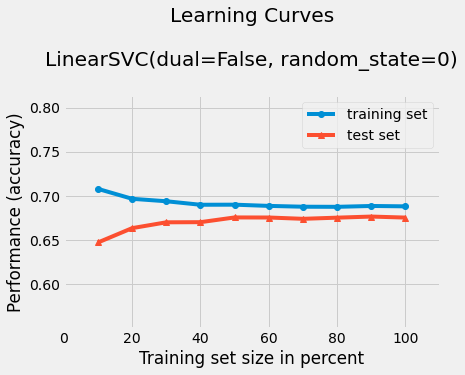

In [28]:
from sklearn import svm
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(pca_x, y_oversampled, test_size=0.2, stratify=y_oversampled, random_state=42)


LinearSVC_clf = svm.LinearSVC(dual=False, multi_class='ovr', random_state=0)

plot_learning_curves(X_train, y_train, X_test, y_test, LinearSVC_clf, scoring= 'accuracy')
plt.show()

In [30]:
from sklearn import svm
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_learning_curves
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


LinearSVC_clf.fit(X_train, y_train)
y_test_predict = LinearSVC_clf.predict(X_test)
y_train_predict = LinearSVC_clf.predict(X_train)
# np.save('y_predict_name_sparse.npy', y_test_predict)
print(accuracy_score(y_test, y_test_predict))
print(accuracy_score(y_train, y_train_predict))


# 0 score for precision, recall and f1 on class label 3...
print(classification_report(y_test, y_test_predict))
cm = confusion_matrix(y_test, y_test_predict)
cm


0.6755021402700033
0.6882074500926116
              precision    recall  f1-score   support

         1.0       0.64      0.65      0.65      4049
         2.0       0.65      0.57      0.61      4049
         3.0       0.73      0.81      0.77      4050

    accuracy                           0.68     12148
   macro avg       0.67      0.68      0.67     12148
weighted avg       0.67      0.68      0.67     12148



array([[2632,  878,  539],
       [1055, 2295,  699],
       [ 418,  353, 3279]], dtype=int64)

In [36]:
# Implements RandomForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

Rd_Forest_clf = RandomForestClassifier(n_estimators=200, max_depth = 4,random_state = 0)


Rd_Forest_clf.fit(X_train, y_train)
Forest_pred = Rd_Forest_clf.predict(X_test)
# Check accuracy of Random Forest
print(accuracy_score(y_test, Forest_pred))
print(classification_report(y_test, Forest_pred))

0.6125288113269673
              precision    recall  f1-score   support

         1.0       0.57      0.68      0.62      4049
         2.0       0.62      0.40      0.49      4049
         3.0       0.65      0.75      0.70      4050

    accuracy                           0.61     12148
   macro avg       0.61      0.61      0.60     12148
weighted avg       0.61      0.61      0.60     12148



In [40]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
estimators = [('rf', Rd_Forest_clf),('svr', make_pipeline(StandardScaler(),LinearSVC_clf))]
              
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
              
clf.fit(X_train, y_train).score(X_test, y_test)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6932005268356931